<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#вывод-по-главе-&quot;Подготовка-данных&quot;" data-toc-modified-id="вывод-по-главе-&quot;Подготовка-данных&quot;-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>вывод по главе "Подготовка данных"</a></span></li></ul></li><li><span><a href="#переработка-комментариев" data-toc-modified-id="переработка-комментариев-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>переработка комментариев</a></span><ul class="toc-item"><li><span><a href="#вывод-по-главе-&quot;переработка-комментариев&quot;" data-toc-modified-id="вывод-по-главе-&quot;переработка-комментариев&quot;-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>вывод по главе "переработка комментариев"</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#вывод-по-главе-&quot;обучение-моделей&quot;" data-toc-modified-id="вывод-по-главе-&quot;обучение-моделей&quot;-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>вывод по главе "обучение моделей"</a></span></li></ul></li><li><span><a href="#тест-лучшей-модели" data-toc-modified-id="тест-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>тест лучшей модели</a></span><ul class="toc-item"><li><span><a href="#вывод-по-главе-&quot;тест-лучшей-модели&quot;" data-toc-modified-id="вывод-по-главе-&quot;тест-лучшей-модели&quot;-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>вывод по главе "тест лучшей модели"</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 2.5 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [41]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import warnings
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

# константы
SEED = 3826
warnings.filterwarnings('ignore')

## Подготовка

In [2]:
df= pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
def data_analis (df):
    i=df.info()
    h=df.head()
    ds=df.describe()
    dp=df.duplicated().sum()
    isna = df.isna().sum()
    i
    display(h)
    display(ds)
    print('дубликаты:',dp)
    print('пропуски:', isna,sep=' ')

In [4]:
data_analis(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


дубликаты: 0
пропуски: Unnamed: 0    0
text          0
toxic         0
dtype: int64


In [5]:
df=df.drop('Unnamed: 0',axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


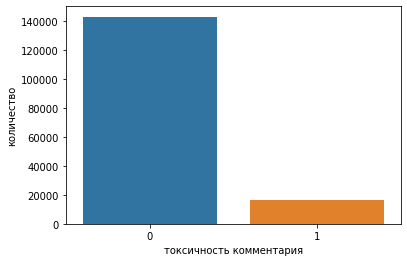

In [7]:
ax=sns.countplot(df['toxic'])
ax.set(xlabel='токсичность комментария',
       ylabel='количество');

<div style="padding: 30px 25px; border: 3px #30D5C8 solid">

### вывод по главе "Подготовка данных"
    
  - загрузили и посмотерли данный
  - удалили лишние стобцы
  - посмотрели распределение классов
    


## переработка комментариев

In [8]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

In [9]:
def x(df):
    lemm_texts=[]
    puncts=[]
    clear=[]
    for doc in tqdm(nlp.pipe(df.values, disable = ['ner', 'parser']), total=df.shape[0]):
        lemm_text = " ".join([i.lemma_ for i in doc])
        lemm_texts.append(lemm_text.lower())
        
    lt=lemm_texts
    
    for stop in lt:
        s=" ".join(s for s in stop.split() if s not in STOP_WORDS)
        puncts.append(s)
    
    for punct in puncts:
        p=" ".join([p for p in punct.split() if p not in punctuations ])
        clear.append(p)
    
    return clear

In [10]:
df['lemm_text']=x(df['text'])

100%|██████████| 159292/159292 [13:23<00:00, 198.34it/s]


In [11]:
display(df.head())

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,d'aww match background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,second time asking view completely contradict ...
159288,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing talk page 128.61.19.93
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm s actual article prostitution ring...
159290,And it looks like it was actually you who put ...,0,look like actually speedy version delete look


In [12]:
tfidf_vector = TfidfVectorizer(max_features=45000,stop_words='english',min_df=10)

<div style="padding: 30px 25px; border: 3px #30D5C8 solid">

### вывод по главе "переработка комментариев"
   - леметизировали текст
   - убрали знаки пунктуации
   - убрали стоп слова
   - закодировали tf-idf
    

## Обучение

In [13]:
features=df['lemm_text']
target = df['toxic']

In [14]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2,
                                                                              random_state=SEED)

print(f'размер тренировочной выборки: {features_train.shape}, {target_train.shape}' )
print(f'размер тестовой выборки:{features_test.shape}, {target_test.shape}')

размер тренировочной выборки: (127433,), (127433,)
размер тестовой выборки:(31859,), (31859,)


In [15]:
%%time
features_train_vectorized = tfidf_vector.fit_transform(features_train)
features_test_vectorized = tfidf_vector.transform(features_test)
# Вывод размерности матрицы TF-IDF
print("Размерность обучающей матрицы TF-IDF:", features_train_vectorized.shape)
print("Размерность тестовой матрицы TF-IDF:", features_test_vectorized.shape)


Размерность обучающей матрицы TF-IDF: (127433, 16052)
Размерность тестовой матрицы TF-IDF: (31859, 16052)
CPU times: user 5.33 s, sys: 40.1 ms, total: 5.37 s
Wall time: 5.38 s


In [16]:
param_grid = {
    'criterion':['entropy'],
    'n_estimators': [10,50,100, 150],
    'max_depth': [2,5,7,15],
    'min_samples_split': [2, 3,5,10],
}

pipe = RandomForestClassifier()

random_search_RF = RandomizedSearchCV(estimator=pipe,
                                      param_distributions=param_grid,
                                      cv=5,
                                      verbose=3,
                                      random_state=SEED,
                                      scoring="f1")

In [17]:
%%time
# обучение модели
random_search_RF.fit(features_train_vectorized, target_train)
# сохраним лучшую модель
best_model_RF = random_search_RF.best_estimator_
# сохраним лучшее значение метрики
final_metrics_RF = random_search_RF.best_score_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=entropy, max_depth=7, min_samples_split=5, n_estimators=10; total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=7, min_samples_split=5, n_estimators=10; total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=7, min_samples_split=5, n_estimators=10; total time=   0.4s
[CV 4/5] END criterion=entropy, max_depth=7, min_samples_split=5, n_estimators=10; total time=   0.4s
[CV 5/5] END criterion=entropy, max_depth=7, min_samples_split=5, n_estimators=10; total time=   0.4s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV 5/5] END crit

In [18]:
print(f'Оптимальные гиперпараметры:\n{random_search_RF.best_params_}\n F-1: {final_metrics_RF}')

Оптимальные гиперпараметры:
{'n_estimators': 10, 'min_samples_split': 3, 'max_depth': 15, 'criterion': 'entropy'}
 F-1: 0.04605490841186605


In [19]:
param_grid = {
   
    'max_depth': [2,5, 7,15],
    'min_samples_split': [2, 3,5,10],
}

dt= DecisionTreeClassifier()


random_search_DT = RandomizedSearchCV(estimator=dt,
                                      param_distributions=param_grid,
                                      cv=5,
                                      verbose=3,
                                      random_state=SEED,
                                      scoring="f1")

In [20]:
%%time
# обучение модели
random_search_DT.fit(features_train_vectorized, target_train)
# сохраним лучшую модель
best_model_DT = random_search_DT.best_estimator_
# сохраним лучшее значение метрики
final_metrics_DT = random_search_DT.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...............max_depth=7, min_samples_split=3; total time=   2.4s
[CV 2/5] END ...............max_depth=7, min_samples_split=3; total time=   2.5s
[CV 3/5] END ...............max_depth=7, min_samples_split=3; total time=   2.4s
[CV 4/5] END ...............max_depth=7, min_samples_split=3; total time=   2.5s
[CV 5/5] END ...............max_depth=7, min_samples_split=3; total time=   2.5s
[CV 1/5] END ...............max_depth=2, min_samples_split=3; total time=   0.8s
[CV 2/5] END ...............max_depth=2, min_samples_split=3; total time=   0.8s
[CV 3/5] END ...............max_depth=2, min_samples_split=3; total time=   0.8s
[CV 4/5] END ...............max_depth=2, min_samples_split=3; total time=   0.7s
[CV 5/5] END ...............max_depth=2, min_samples_split=3; total time=   0.8s
[CV 1/5] END ..............max_depth=7, min_samples_split=10; total time=   2.7s
[CV 2/5] END ..............max_depth=7, min_samp

In [21]:
print(f'Оптимальные гиперпараметры:\n{random_search_DT.best_params_}\n f-1: {final_metrics_DT}')

Оптимальные гиперпараметры:
{'min_samples_split': 5, 'max_depth': 15}
 f-1: 0.6379621312987234


In [28]:
grid = {
        'iterations': [100,120],
        'learning_rate': [1,0.1,0.01],
        'depth': [2,5,7]
       }
model_cat= CatBoostClassifier(loss_function='Logloss', eval_metric='F1')

In [32]:
# обучение модели
catboost_grid = RandomizedSearchCV(estimator=model_cat,
                                   param_distributions=grid,
                                      cv=2, 
                                  verbose=2,
                                  random_state=SEED,
                                  scoring='f1')


In [33]:
%%time
catboost_grid.fit(features_train_vectorized,target_train)
# сохраним лучшую модель
best_model_CB = catboost_grid.best_estimator_
# сохраним лучшее значение метрики
final_metrics_CB = best_model_CB.best_score_

Fitting 2 folds for each of 6 candidates, totalling 12 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.2731395	total: 331ms	remaining: 32.7s
1:	learn: 0.4251590	total: 631ms	remaining: 30.9s
2:	learn: 0.5043923	total: 932ms	remaining: 30.1s
3:	learn: 0.5627320	total: 1.23s	remaining: 29.5s
4:	learn: 0.5895250	total: 1.53s	remaining: 29s
5:	learn: 0.6056820	total: 1.82s	remaining: 28.5s
6:	learn: 0.6278018	total: 2.11s	remaining: 28.1s
7:	learn: 0.6405673	total: 2.4s	remaining: 27.6s
8:	learn: 0.6535456	total: 2.72s	remaining: 27.5s
9:	learn: 0.6639336	total: 3s	remaining: 27s
10:	learn: 0.6657682	total: 3.29s	remaining: 26.6s
11:	learn: 0.6747929	total: 3.57s	remaining: 26.2s
12:	learn: 0.6784291	total: 3.85s	remaining: 25.8s
13:	learn: 0.6857841	total: 4.14s	remaining: 25.4s
14:	learn: 0.6865139	total: 4.43s	remaining: 25.1s
15:	learn: 0.6915330	total: 4.72s	remaining: 24.8s
16:	learn: 0.6961193	total: 5.01s	remaining: 24.5s
17:	learn: 0.6989664	total: 5.32s	remaining: 24.2s
18:	learn: 0.7027872	total: 5.63s	remaining: 24s
19:	learn: 0.7058716	total: 5.92s	remaining: 23.7s


In [34]:
print(f'Оптимальные гиперпараметры:\n{catboost_grid.best_params_}\n f-1: {final_metrics_CB}')

Оптимальные гиперпараметры:
{'learning_rate': 1, 'iterations': 120, 'depth': 5}
 f-1: {'learn': {'Logloss': 0.10568883029560532, 'F1': 0.8154046012655576}}


<div style="padding: 30px 25px; border: 3px #30D5C8 solid">

### вывод по главе "обучение моделей"
- векторизировали данные
- обучили 3 модели
- выбрали лучшую
---
лучшая модель это catboost с параметрами и значением f1 на тренировочной выборке:
    
   - кол-во итераций: 120,
   - скорость обучения: 1
   - глубина: 7
   - F1: 81%

## тест лучшей модели

In [44]:
pred=best_model_CB.predict(features_test_vectorized)
print(f1_score(target_test,pred))

0.7643397813288477


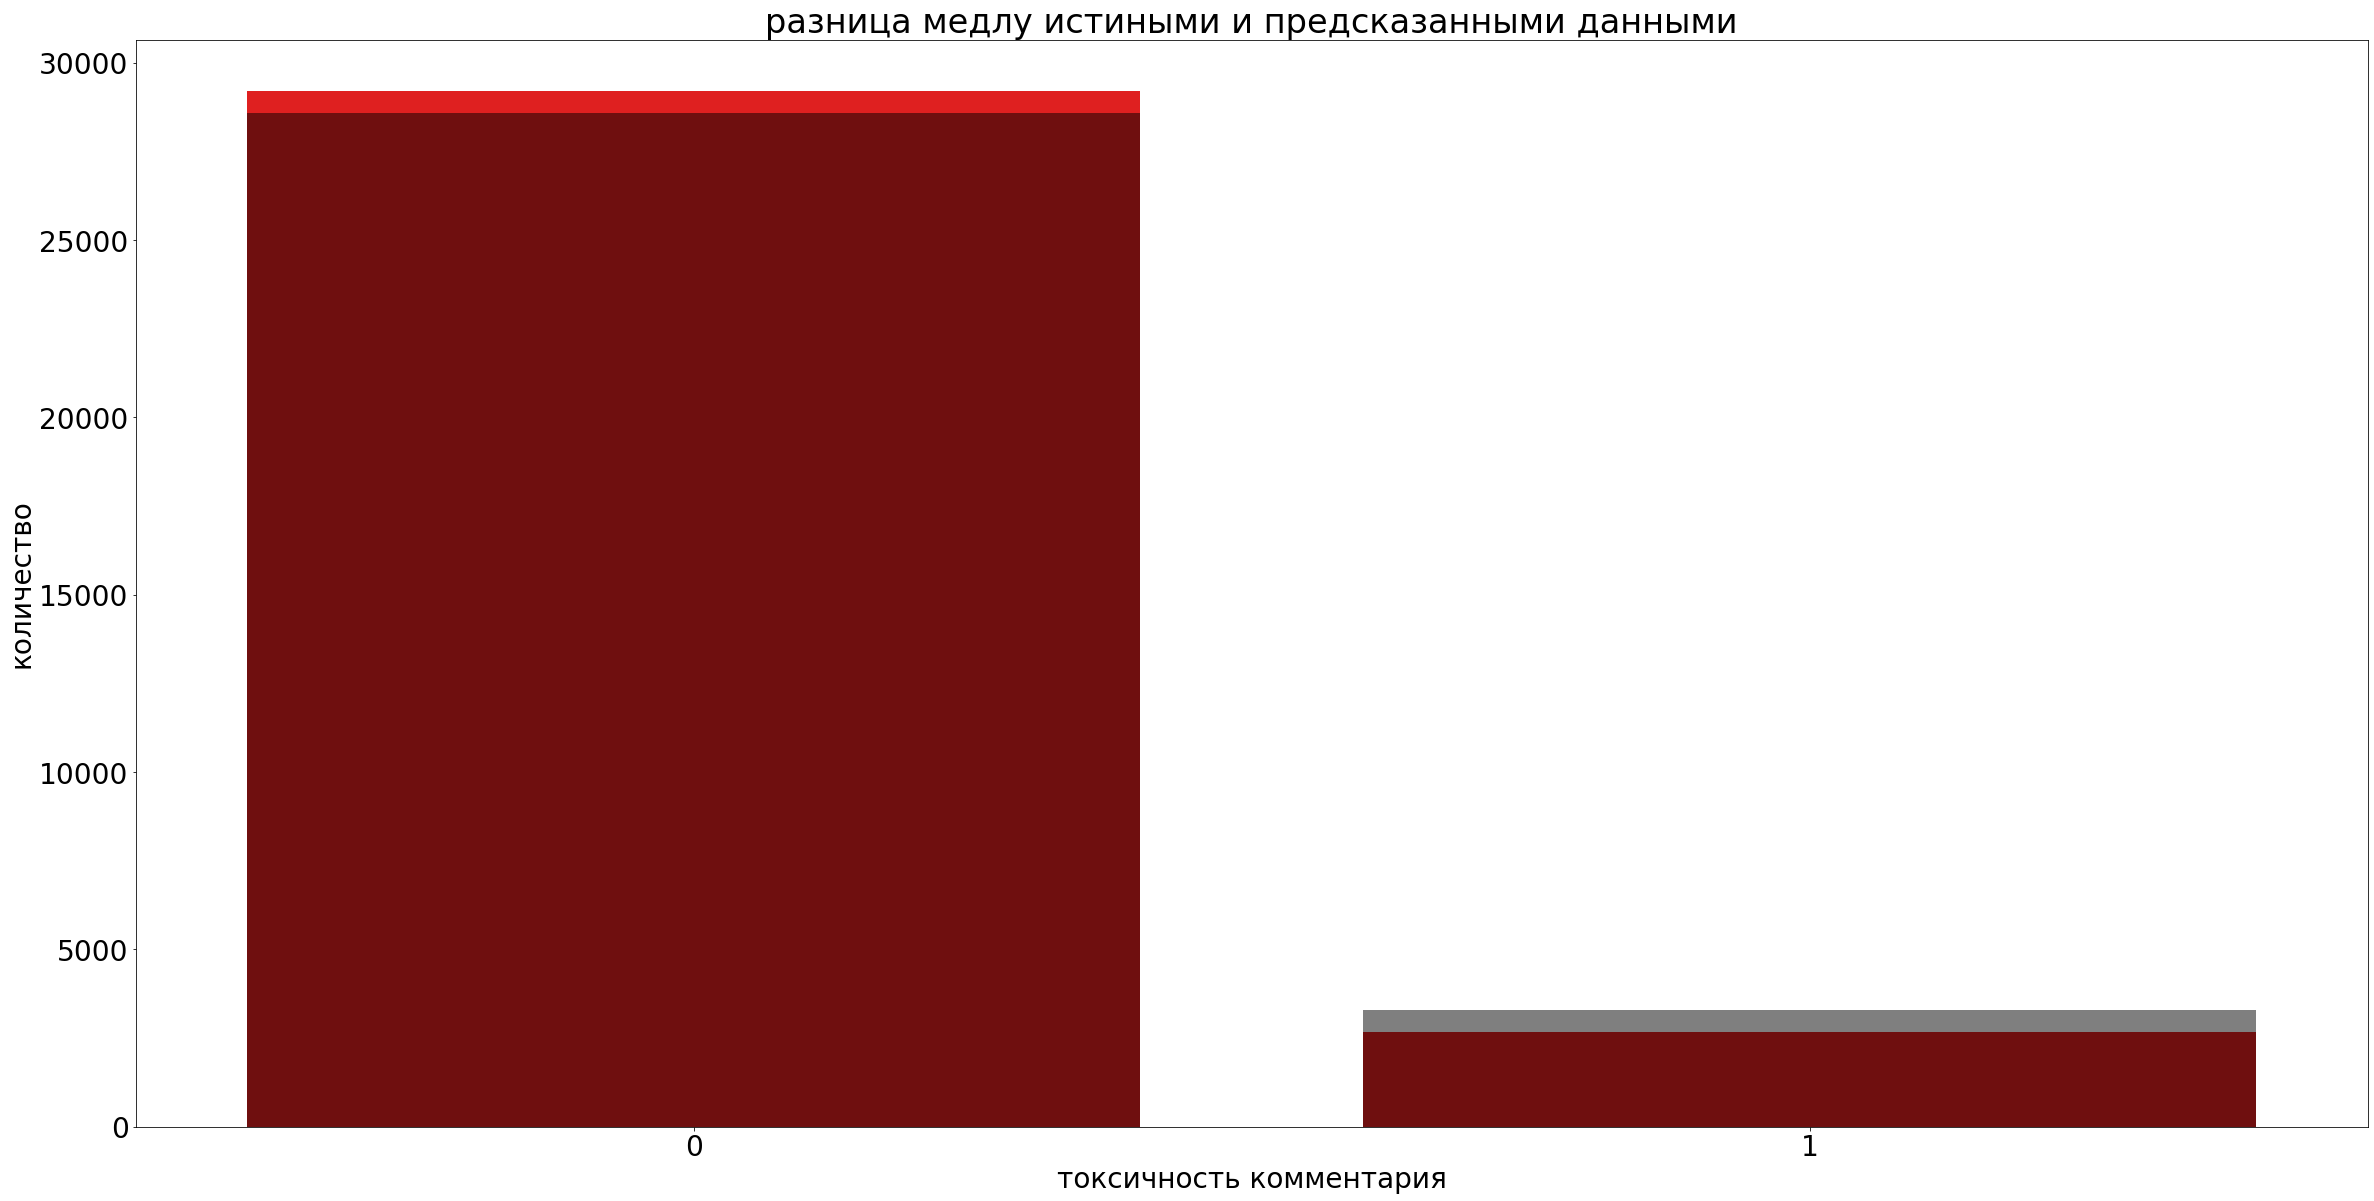

In [107]:
plt.figure(figsize=(40, 20))

bx=sns.countplot(pred, color='red',)
bx.set(xlabel='токсичность комментария',
       ylabel='количество');

ax=sns.countplot(target_test,color='black',alpha=0.5)
ax.set(label = 'истинные',
        xlabel='токсичность комментария',
        ylabel='количество',
         title='разница медлу истиными и предсказанными данными');

<div style="padding: 30px 25px; border: 3px #30D5C8 solid">

### вывод по главе "тест лучшей модели"
    - протестировали лучшую модели и получили значение F1: 76%
    - визуализировали различия между предсказаниями и реальным данными

<div style="padding: 30px 25px; border: 3px red solid">
    
## Выводы
- загрузили и обработали данные используя spacy,puncuation,stop_words
- векторезировали комментарии с помощью tf-idf 
- на векорезированных данных обучили 3 модели, выбрали и протестировали лучшую 
   - получили значение метрики f1 на тестовой выборке в 76%, что по условиям проекта достаточно
    
- постоили график расхождения предсказаний модели относительно реальных данных